In [127]:
import torch
from torch_geometric.explain import Explainer

In [128]:
EXP = 1; K=22

In [129]:
exp = torch.load(f'explaination-{EXP}.pt')
g = torch.load('xgnn_graph.pt')
target = g.target[EXP]
print(f"Analysis for node {target.item()}")
# exp.visualize_graph(node_labels=g.node_str) # Doesn't work in geo 2.4, can't upgrade bc breaks mp.propagate

sg = exp.get_explanation_subgraph()
nodes = exp.node_mask.nonzero()[:,0]
ei = sg.edge_index
ew = sg.edge_mask
nm = exp.node_mask[nodes].squeeze(-1)

ntypes = g.x[nodes, :5]
ntypes = ntypes.nonzero()[:, 1]
typemap = ['blue', 'yellow', 'green', 'grey', 'pink']
ntypes = {i:typemap[n.item()] for i,n in enumerate(ntypes)}

names = dict()
for i,node in enumerate(nodes):
    names[i] = g.node_str[node.item()]
    if node.item() == target.item():
        names[i] = 'TARGET'
        nm[i] = 100
        ntypes[i] = 'red'

print(ei.max())
print(names)
print(ntypes)


Analysis for node 1
tensor(1271)
{0: 'TARGET', 1: 'APT28', 2: '179.43.128.218', 3: 'wmiapp.com', 4: '92.114.92.134', 5: 'unisecproper.org', 6: 'dmsclock.org', 7: '89.187.151.16', 8: '185.86.150.188', 9: 'systemfromcuriousmoment.com', 10: 'societyatcuriousteacher.com', 11: '5.255.80.50', 12: 'driverfordell.com', 13: '208.91.197.91', 14: '5.135.199.10', 15: 'intelstatistics.com', 16: 'knightconsults.com', 17: '174.128.253.215', 18: '185.86.150.151', 19: 'lopback.com', 20: '188.241.68.175', 21: 'perfect-remote-service.com', 22: '86.105.1.114', 23: 'probenet.eu', 24: '185.94.192.101', 25: 'remonitor.net', 26: 'unitedprosoftcompany.org', 27: '213.252.244.105', 28: '90update.com', 29: '213.252.244.114', 30: 'aljazeera-news.com', 31: '185.25.51.38', 32: 'ambcomission.com', 33: '213.252.246.24', 34: 'cryptokind.com', 35: '185.25.48.249', 36: 'deshcoin.com', 37: '89.44.103.18', 38: 'spelns.com', 39: '86.105.1.12', 40: 'nethostnet.com', 41: '185.94.190.199', 42: 'hostsvcnet.com', 43: 'dochardpro

/tmp/ipykernel_83027/4118538159.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(f'../explaination-{EXP}.pt')
/tmp/ipykernel_83027/4118538159.py:2: Futur

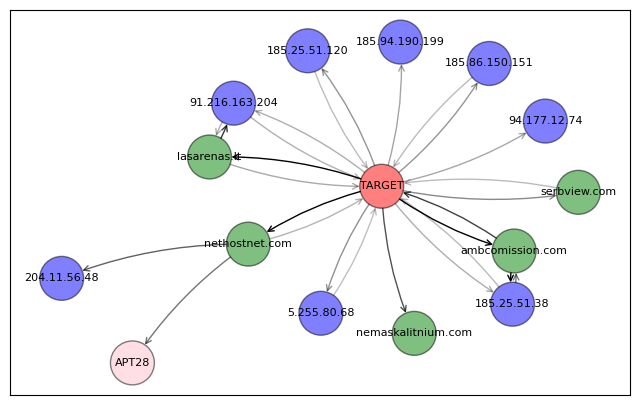

In [134]:
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

def filter(edges, edge_weight, nodemask, k=25):
    important = nodemask.topk(k).indices

    src_mask = (important.unsqueeze(-1) == edges[0]).sum(dim=0).bool()
    dst_mask = (important.unsqueeze(-1) == edges[1]).sum(dim=0).bool()
    edge_mask = src_mask.logical_and(dst_mask)

    edges = edges[:, edge_mask]
    edge_weight = edge_weight[edge_mask]

    return edges,edge_weight

def visualize(node_names, edge_index, edge_weight):
    ''' Taken from pyg.visualization.graph:_visualize_graph_via_networkx
    '''
    g = nx.DiGraph()
    node_size = 1000

    # Normalize edge weights.
    edge_weight = edge_weight - edge_weight.min()
    edge_weight = edge_weight / edge_weight.max()

    # Make min edge weight for better viz
    edge_weight += 0.25
    edge_weight = edge_weight.clamp(0,1)

    for node in edge_index.view(-1).unique().tolist():
        g.add_node(node)

    for (src, dst), w in zip(edge_index.t().tolist(), edge_weight.tolist()):
        g.add_edge(src, dst, alpha=w)

    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(8,5)
    pos = nx.spring_layout(g)
    for src, dst, data in g.edges(data=True):
        ax.annotate(
            '',
            xy=pos[src],
            xytext=pos[dst],
            arrowprops=dict(
                arrowstyle="->",
                alpha=data['alpha'],
                shrinkA=sqrt(node_size) / 2.0,
                shrinkB=sqrt(node_size) / 2.0,
                connectionstyle="arc3,rad=0.1",
            ),
        )

    colors = [ntypes[i] for i in g.nodes()]
    nodes = nx.draw_networkx_nodes(g, pos, node_size=node_size,
                                   node_color=colors, margins=0.1, alpha=0.5)
    nodes.set_edgecolor('black')

    names = {i:node_names[i] for i in g.nodes()}
    nx.draw_networkx_labels(g, pos, font_size=8, labels=names)
    plt.show()
    plt.close()

ei_,ew_ = filter(ei, ew, nm, k=K)
visualize(names, ei_, ew_)